In [1]:
import pandas as pd
# import re
# import pandas_datareader as dr
from datetime import datetime

from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
%store -r

Stored 'tsla_tweets_df' (DataFrame)
Stored 'tsla_stock_values_df' (DataFrame)
Stored 'ta_df' (DataFrame)
Stored 'tsla_sentiments_df' (DataFrame)
Stored 'tsla_sentiments_df_textblob' (DataFrame)


<AxesSubplot:xlabel='Date'>

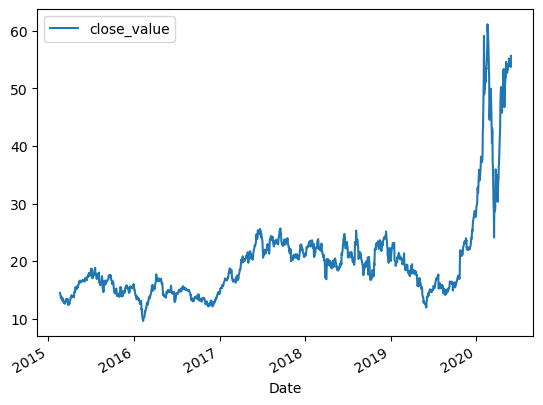

In [2]:
%run PrepareData.ipynb
ta_df.plot(y="close_value")

In [3]:
def get_training_testing_data(dataframe,random=False,test_size=.25):
    y = dataframe["price_direction"]
    X = dataframe.drop(["price_direction"],axis=1)
    if(random):
        # Split the dataset using train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=test_size,random_state=1)
    else:
        train_data_size = int (len(dataframe) * (1-test_size))
        test_data_size = len(dataframe) - train_data_size
        
        train_start = X.index.min()
        train_end = X.index.min() + pd.DateOffset(days=train_data_size)      
        X_train = X.loc[train_start:train_end]
        y_train = y.loc[train_start:train_end]
        
        test_start = train_end + pd.DateOffset(hours=1)         
        X_test = X.loc[test_start:]
        y_test = y.loc[test_start:]
    
    return X_train, X_test, y_train, y_test       
            

In [4]:
def get_optimal_k_neighbors(maxnum,X_scaled_data,y_scaled_data):
    k_neighbors = [num for num in range(1,maxnum,2)]

    k_acc_scores = []

    for k in k_neighbors:
        knn = KNeighborsClassifier(n_neighbors=k)
        cv_scores = cross_val_score(knn, X_scaled_data,y_scaled_data,cv=5, scoring="accuracy")
        k_acc_scores.append(cv_scores.mean())

    return k_neighbors[k_acc_scores.index(max(k_acc_scores))]
        

In [5]:
def exe_knn_model(dataset,test_size=.25,max_neighbors=100,random_data=False):  
 
    
    X_train, X_test, y_train, y_test = get_training_testing_data(dataset,test_size = .3,random=random_data)

    scaler = StandardScaler()

    # Fitting Standard Scaler
    X_scaler = scaler.fit(X_train)

    # Scaling data
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    optimal_k_neighbors = get_optimal_k_neighbors(maxnum=max_neighbors,X_scaled_data=X_train_scaled,y_scaled_data=y_train)
    print(f"Optimal value of n_neighbors is {optimal_k_neighbors}")
    knn_model = KNeighborsClassifier(n_neighbors=optimal_k_neighbors)
    
    # Train model using training data
    knn_model.fit(X_train_scaled, y_train)
    
    # Create predictions using the testing data
    y_pred = knn_model.predict(X_test_scaled)
    
    # Print the classification report comparing the testing data to the model predictions
    print(classification_report(y_test, y_pred))

In [6]:
# For correct mapping with price_direction, get technical indicators of previous day
ta_df_temp = ta_df.loc[:, ta_df.columns != 'price_direction'].shift(1)
ta_df_temp['price_direction'] = ta_df['price_direction']
ta_df_temp.dropna(inplace= True)

In [7]:
exe_knn_model(dataset=ta_df_temp,test_size=.2,max_neighbors=20)

Optimal value of n_neighbors is 5
              precision    recall  f1-score   support

           0       0.49      0.54      0.51       339
           1       0.50      0.44      0.47       345

    accuracy                           0.49       684
   macro avg       0.49      0.49      0.49       684
weighted avg       0.49      0.49      0.49       684



In [8]:
exe_knn_model(dataset=ta_df_temp,test_size=.2,max_neighbors=50)

Optimal value of n_neighbors is 45
              precision    recall  f1-score   support

           0       0.47      0.47      0.47       339
           1       0.48      0.48      0.48       345

    accuracy                           0.48       684
   macro avg       0.48      0.48      0.48       684
weighted avg       0.48      0.48      0.48       684



In [9]:
exe_knn_model(dataset=ta_df_temp,test_size=.2,max_neighbors=100)

Optimal value of n_neighbors is 99
              precision    recall  f1-score   support

           0       0.47      0.42      0.44       339
           1       0.48      0.53      0.51       345

    accuracy                           0.48       684
   macro avg       0.48      0.48      0.47       684
weighted avg       0.48      0.48      0.47       684



In [10]:
exe_knn_model(dataset=ta_df_temp,test_size=.2,max_neighbors=200)

Optimal value of n_neighbors is 99
              precision    recall  f1-score   support

           0       0.47      0.42      0.44       339
           1       0.48      0.53      0.51       345

    accuracy                           0.48       684
   macro avg       0.48      0.48      0.47       684
weighted avg       0.48      0.48      0.47       684



In [11]:
exe_knn_model(dataset=ta_df_temp,test_size=.3,random_data=True)

Optimal value of n_neighbors is 19
              precision    recall  f1-score   support

           0       0.48      0.37      0.42       207
           1       0.45      0.56      0.50       192

    accuracy                           0.46       399
   macro avg       0.46      0.46      0.46       399
weighted avg       0.46      0.46      0.46       399



In [12]:
ta_df_vader_temp = pd.concat([ta_df_temp,tsla_sentiments_df],axis=1, join="inner")

exe_knn_model(dataset=ta_df_vader_temp,test_size=.3)

Optimal value of n_neighbors is 63
              precision    recall  f1-score   support

           0       0.51      0.48      0.50       318
           1       0.50      0.53      0.52       313

    accuracy                           0.51       631
   macro avg       0.51      0.51      0.51       631
weighted avg       0.51      0.51      0.51       631



In [13]:
ta_df_text_blob_temp = pd.concat([ta_df_temp,tsla_sentiments_df_textblob],axis=1, join="inner")

exe_knn_model(dataset=ta_df_text_blob_temp,test_size=.3)

Optimal value of n_neighbors is 81
              precision    recall  f1-score   support

           0       0.43      0.25      0.32       318
           1       0.47      0.66      0.54       313

    accuracy                           0.45       631
   macro avg       0.45      0.46      0.43       631
weighted avg       0.45      0.45      0.43       631



In [14]:
start_date = ta_df.index.max()
end_data = start_date + pd.DateOffset(days=30)